In [1]:
import numpy as np
import pickle
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
METHOD = 'cnn_autoencoder'

LABELLED_DATA_FILE = 'data/all_label.p'
UNLABELED_DATA_FILE = 'data/all_unlabel.p'
TEST_DATA_FILE = 'data/test.p'

OUTPUT_FOLDER = 'output/'
MODEL_FOLDER = 'model/' + METHOD + '/'

In [3]:
import os
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Train

### Loading Training Data

In [4]:
labelled_data = np.array(pickle.load(open(LABELLED_DATA_FILE, 'rb')))
unlabeled_data = np.array(pickle.load(open(UNLABELED_DATA_FILE, 'rb')))

In [5]:
nb_classes = 10
img_rows, img_cols, img_channels = 32, 32, 3

In [6]:
# generate x, y from data

# reshape labelled data to (5000, 3, 32, 32)
X_train_label = labelled_data.reshape((5000, img_channels, img_rows, img_cols)).astype('float32') / 255

# reshape unlabeled data to (45000, 3, 32, 32)
nb_unlabeled_data = unlabeled_data.shape[0]
X_train_unlabel = unlabeled_data.reshape((nb_unlabeled_data, img_channels, img_rows, img_cols)).astype('float32') / 255

X_train_all = np.concatenate((X_train_label, X_train_unlabel))

y_train_label_class = np.array([classIdx for classIdx in range(len(labelled_data)) for i in range(len(labelled_data[classIdx]))])
Y_train_label = np_utils.to_categorical(y_train_label_class, nb_classes)

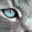

In [7]:
# visualize
from scipy.misc import toimage
toimage(X_train_unlabel[5])

### Training

#### autoencoder

In [8]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(3, 32, 32))

x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(input_img)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = MaxPooling2D((2, 2), dim_ordering="th")(x)

encoded_1 = x

x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(input_img)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(input_img)
x = AveragePooling2D((2, 2), border_mode='same', dim_ordering="th")(x)

encoded_2 = x

x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)

x = Convolution2D(16, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
# x = AveragePooling2D((2, 2), border_mode='same', dim_ordering="th")(x)

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = AveragePooling2D((2, 2), dim_ordering="th")(x)

encoded = x

x = UpSampling2D((2, 2), dim_ordering="th")(x)
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = UpSampling2D((2, 2), dim_ordering="th")(x)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
# x = UpSampling2D((2, 2), dim_ordering="th")(x)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering="th")(x)
# x = UpSampling2D((2, 2), dim_ordering="th")(x)
decoded = Convolution2D(3, 3, 3, activation='sigmoid', border_mode='same', dim_ordering="th")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
nb_epoch = 15
batch_size = 64

In [10]:
autoencoder.fit(X_train_all, X_train_all,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True)

Epoch 1/1
50000/50000 [==============================] - 47s - loss: 0.5705    


In [11]:
encoder_1 = Model(input=input_img, output=encoded_1)
encoder_2 = Model(input=input_img, output=encoded_2)

In [12]:
X_train_label_encoded_1 = encoder_1.predict(X_train_label)
X_train_label_encoded_2 = encoder_2.predict(X_train_label)

In [13]:
encoder = Model(input=input_img, output=encoded)

#### classify

In [18]:
classifier = Sequential()

classifier.add(Flatten(input_shape=X_train_label_encoded_2.shape[1:]))

classifier.add(Dense(512))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(256))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(128))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(nb_classes))
classifier.add(Activation('softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
nb_epoch = 100
batch_size = 64

In [20]:
classifier.fit(X_train_label_encoded_2, Y_train_label,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    shuffle=True)

Epoch 1/10
5000/5000 [==============================] - 1s - loss: 2.3902 - acc: 0.1186     
Epoch 2/10
5000/5000 [==============================] - 0s - loss: 2.2073 - acc: 0.1646     
Epoch 3/10
5000/5000 [==============================] - 0s - loss: 2.1347 - acc: 0.1816     
Epoch 4/10
5000/5000 [==============================] - 1s - loss: 2.0967 - acc: 0.1994     
Epoch 5/10
5000/5000 [==============================] - 0s - loss: 2.0757 - acc: 0.2032     
Epoch 6/10
5000/5000 [==============================] - 0s - loss: 2.0308 - acc: 0.2196     
Epoch 7/10
5000/5000 [==============================] - 0s - loss: 2.0218 - acc: 0.2246     
Epoch 8/10
5000/5000 [==============================] - 0s - loss: 2.0034 - acc: 0.2254     
Epoch 9/10
5000/5000 [==============================] - 0s - loss: 2.0033 - acc: 0.2316     
Epoch 10/10
5000/5000 [==============================] - 0s - loss: 1.9915 - acc: 0.2202     


In [23]:
model = Sequential()

model.add(encoder_2)
model.add(classifier)

model.save("model_auto_test")

# Test

### Loading test data 

In [24]:
test_data = pickle.load(open(TEST_DATA_FILE, 'rb'))  # dict
X_test = np.array(test_data['data']).reshape((10000, 3, 32, 32)).astype('float32') / 255

### Predict

In [26]:
Y_test = model.predict_classes(X_test)
csv_content = list(zip(test_data['ID'], Y_test.tolist()))
np.savetxt("out_auto_test.csv", csv_content, fmt="%i", header="ID,class", comments="", delimiter=",")

 9952/10000 [============================>.] - ETA: 0s

In [ ]:
# X_test_encoded = encoder_2.predict(X_test)
# Y_test = classifier.predict_classes(X_test_encoded)
# csv_content = list(zip(test_data['ID'], Y_test.tolist()))
# np.savetxt(OUTPUT_FOLDER + model_name + ".csv", csv_content, fmt="%i", header="ID,class", comments="", delimiter=",")